In [158]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.tsa.api import SARIMAX

In [159]:
palette_tab10 = sns.color_palette("tab10", 10)
cmap = sns.color_palette([palette_tab10[0], palette_tab10[1]], as_cmap=True)
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

Read the data

In [160]:
DIR_SUBJECT_1 = '../udataset/meat/production.csv'
# DIR_SUBJECT_1 = '../udataset/meat/cold_storage.csv'
# DIR_SUBJECT_1 = '../udataset/meat/slaughter.csv'
# DIR_SUBJECT_1 = '../udataset/meat/weights.csv'
df_subject1 = pd.read_csv(DIR_SUBJECT_1)
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Other Chicken,Turkey,Red Meat,Poultry
0,1921-01,3.580000e+08,27000000.0,5.650000e+08,44000000.0,NaN,NaN,393000000.0,9.940000e+08,3.930000e+08
1,1921-02,2.790000e+08,24000000.0,4.840000e+08,39000000.0,NaN,NaN,NaN,8.260000e+08,0.000000e+00
2,1921-03,3.400000e+08,31000000.0,3.720000e+08,45000000.0,NaN,NaN,NaN,7.880000e+08,0.000000e+00
3,1921-04,3.160000e+08,29000000.0,3.740000e+08,41000000.0,NaN,NaN,NaN,7.600000e+08,0.000000e+00
4,1921-05,3.190000e+08,31000000.0,3.960000e+08,37000000.0,NaN,NaN,NaN,7.830000e+08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,51100000.0,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,48400000.0,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,50600000.0,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,44500000.0,500300000.0,4.638900e+09,4.362100e+09


In [161]:
# DIR_SUBJECT_2 = '../udataset/unemployment_month_US.csv'
# DIR_SUBJECT_2 = '../dataset/youth_unemployment_rate.csv'
DIR_SUBJECT_2 = '../dataset/national_hourly_earnings.csv'
df_subject2 = pd.read_csv(DIR_SUBJECT_2)
df_subject2

,YearMonth,HourlyEarnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Make variables for specific dataset 1

In [162]:
# For meat production
df_subject1 = df_subject1.drop(columns=['Other Chicken'])
df_subject1 = df_subject1.dropna()
MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'red_meat', 'poultry']
SUBJECT1 = 'meat_production'
UNIT = 'Pounds'

# For meat cold storage
# MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'frozen_egg', 'red_meat', 'poultry']

SUBJECT_TITLE1 = SUBJECT1.replace('_', ' ').title()
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Turkey,Red Meat,Poultry
648,1977-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
649,1977-02,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
650,1977-03,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
651,1977-04,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
652,1977-05,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


Make variables for specific dataset 2

In [163]:
# # For unemployment_month_US.csv
# df_subject2 = df_subject2.rename(columns={'Year-Month': 'datetime'})
# SUBJECT2 = 'unemployment_rate'

# # For youth_unemployment_rate.csv
# df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'UnemploymentRate': 'unemployment_rate'})
# SUBJECT2 = 'unemployment_rate'

# For national_hourly_earnings.csv
df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'HourlyEarnings': 'hourly_earnings'})
SUBJECT2 = 'hourly_earnings'

SUBJECT_TITLE2 = SUBJECT2.replace('_', ' ').title()
df_subject2

,datetime,hourly_earnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Change label format to be lower + underscores instead of space

In [164]:
df_subject1.columns = df_subject1.columns.str.lower().str.replace(' ', '_')
df_subject2.columns = df_subject2.columns.str.lower().str.replace(' ', '_')

Change date format to better use together

In [165]:
df_subject1['datetime'] = pd.to_datetime(df_subject1['datetime'])
df_subject2['datetime'] = pd.to_datetime(df_subject2['datetime'])
df_subject2

,datetime,hourly_earnings
0,2006-03-01,20.07
1,2006-04-01,20.36
2,2006-05-01,20.06
3,2006-06-01,20.04
4,2006-07-01,20.28
...,...,...
212,2023-11-01,34.08
213,2023-12-01,34.26
214,2024-01-01,34.67
215,2024-02-01,34.61


In [166]:
df_subject1 = df_subject1.iloc[::-1]
df_subject1.reset_index(drop=True, inplace=True)
df_subject1

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
0,2023-12-01,2.158900e+09,3700000.0,2.332400e+09,9500000.0,3.615000e+09,449200000.0,4.504500e+09,4.105700e+09
1,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09
2,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
3,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
4,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
...,...,...,...,...,...,...,...,...,...
551,1977-05-01,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
552,1977-04-01,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
553,1977-03-01,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
554,1977-02-01,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08


Plot meat data

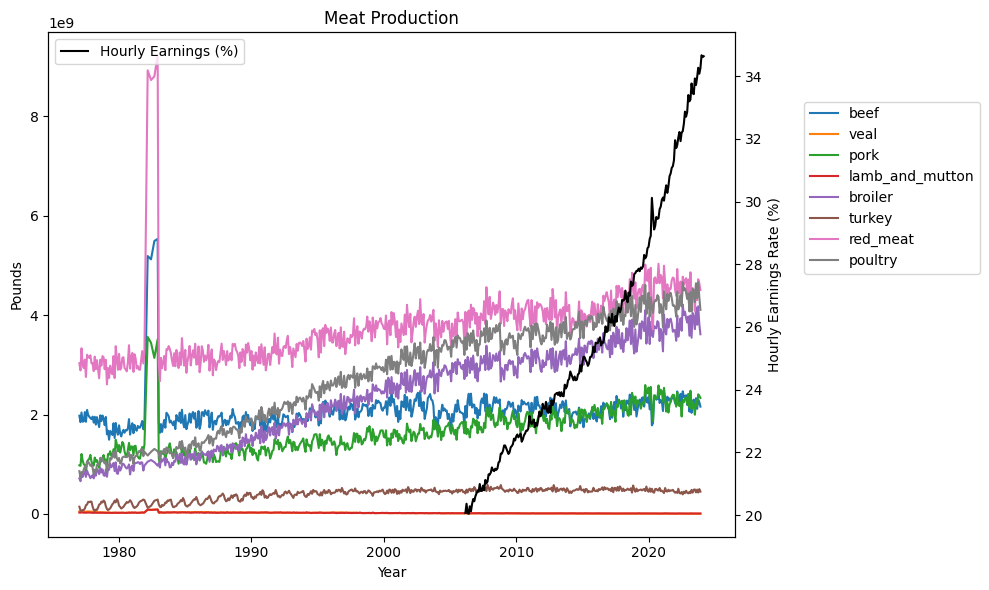

In [167]:
df_temp = pd.melt(df_subject1, id_vars='datetime', var_name='meat', value_name='amount')
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df_temp, x='datetime', y='amount', hue='meat')
ax.set_title(SUBJECT_TITLE1)
ax.set_xlabel('Year')
ax.set_ylabel(UNIT)
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=5)
ax2 = ax.twinx()
sns.lineplot(data=df_subject2, x='datetime', y=SUBJECT2, color='black', label=f'{SUBJECT_TITLE2} (%)', ax=ax2)
ax2.set_ylabel(f'{SUBJECT_TITLE2} Rate (%)')

plt.tight_layout()
plt.show()

Plot subject data

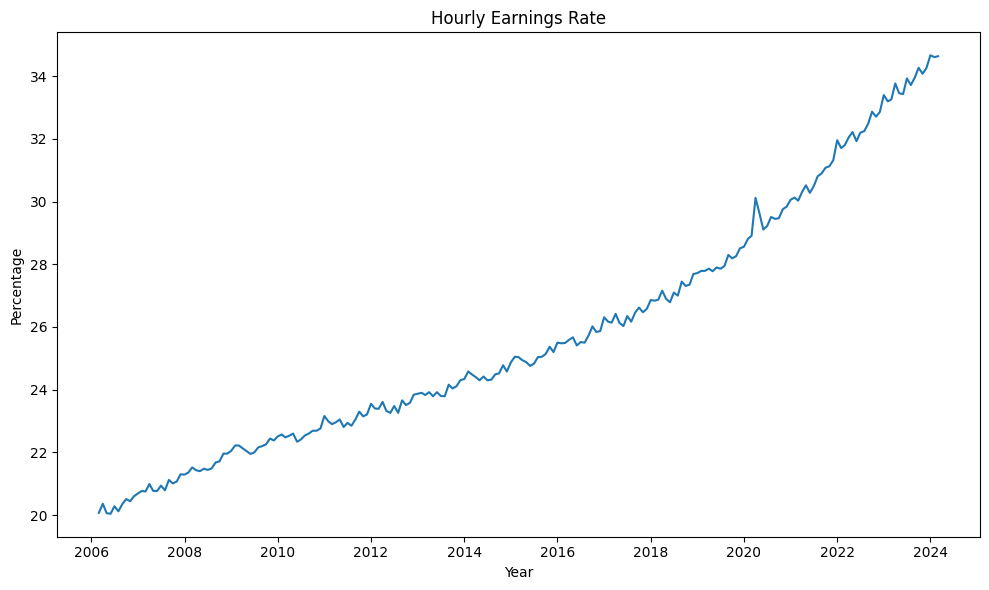

In [168]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df_subject2, x='datetime', y=SUBJECT2)
ax.set_title(f'{SUBJECT_TITLE2} Rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
plt.tight_layout()
plt.show()

Calculate and plot rolling mean and std for meat

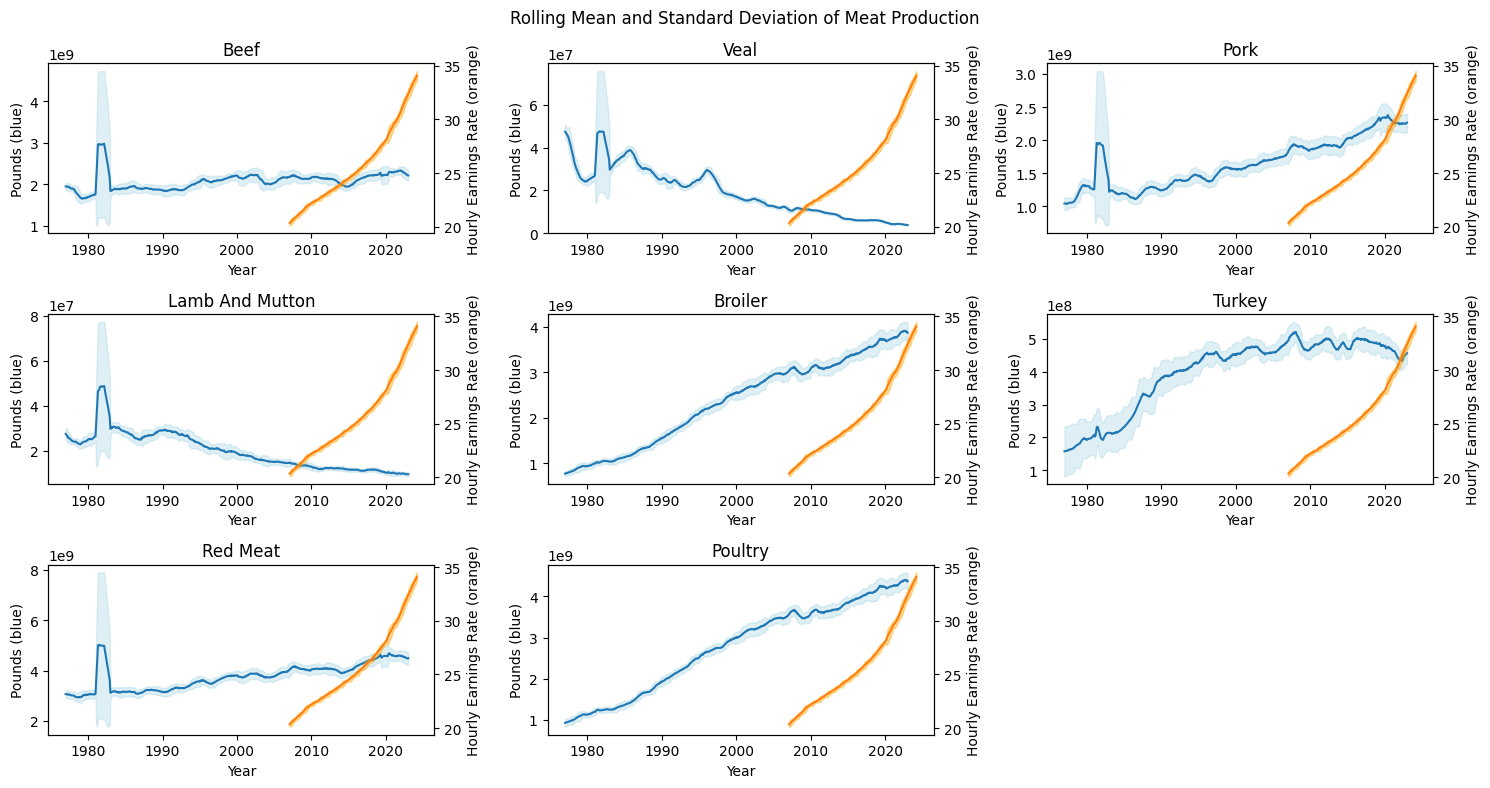

In [169]:
df_temp = df_subject1.copy()
for meat in MEAT_TYPE:
    df_temp[f'rolling_mean_{meat}'] = df_temp[meat].rolling(window=12).mean()
    df_temp[f'rolling_std_{meat}'] = df_temp[meat].rolling(window=12).std()
df_temp = df_temp.dropna()

df_temp2 = df_subject2.copy()
df_temp2['rolling_mean'] = df_temp2[SUBJECT2].rolling(window=12).mean()
df_temp2['rolling_std'] = df_temp2[SUBJECT2].rolling(window=12).std()
df_temp2 = df_temp2.dropna()

plt.figure(figsize=(15, 8))
plt.suptitle('Rolling Mean and Standard Deviation of Meat Production')
for i, meat in enumerate(MEAT_TYPE):
    mean_meat = df_temp[f'rolling_mean_{meat}']
    std_meat = df_temp[f'rolling_std_{meat}']
    ax = plt.subplot(3, 3, i+1)
    sns.lineplot(data=df_temp, x='datetime', y=f'rolling_mean_{meat}', color=cmap[0], label='', ax=ax)
    ax.fill_between(df_temp['datetime'], mean_meat-std_meat, mean_meat+std_meat, color='lightblue', alpha=0.4)
    title = meat.replace('_', ' ').title()
    ax.set_title(title)
    ax.set_ylabel(f'{UNIT} (blue)')
    ax.set_xlabel('Year')

    mean_subject = df_temp2['rolling_mean']
    std_subject = df_temp2['rolling_std']
    ax2 = ax.twinx()
    sns.lineplot(data=df_temp2, x='datetime', y='rolling_mean', color=cmap[1], ax=ax2)
    ax2.fill_between(df_temp2['datetime'], mean_subject-std_subject, mean_subject+std_subject, color='orange', alpha=0.4)
    ax2.set_ylabel(f'{SUBJECT_TITLE2} Rate (orange)')

plt.tight_layout()
plt.show()

# Stationary analysis

Check for stationarity

In [170]:
def test_stationarity(timeseries, title):
    title = title.replace('_', ' ').title()

    result = adfuller(timeseries, autolag='AIC')
    adf_stat = result[0]
    p_val = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_val = result[4]
    icbest = result[5]

    # Print the results in a more structured report format
    print(f"Augmented Dickey-Fuller Test Results for {title}:")
    print("-------------------------------------")
    print(f"Test Statistic: {adf_stat:.4f}")
    print(f"P-value: {p_val:.4f}")
    print(f"Number of Lags Used: {used_lag}")
    print(f"Number of Observations Used: {n_obs}")
    print("Critical Values:")
    for key, value in critical_val.items():
        print(f"    {key} ({value:.4f})")
    print(f"Information Criterion (best): {icbest:.4f}")

    # Provide a basic conclusion
    print("Conclusion:")
    if p_val < 0.05:
        print("The time series is stationary with 95% confidence.")
        return 1
    else:
        print("The time series is not stationary. Consider differencing or detrending.")
        return 0

for meat in MEAT_TYPE:
    test_stationarity(df_subject1[meat], meat)
    print('\n')

Augmented Dickey-Fuller Test Results for Beef:
-------------------------------------
Test Statistic: -4.9639
P-value: 0.0000
Number of Lags Used: 10
Number of Observations Used: 545
Critical Values:
    1% (-3.4424)
    5% (-2.8669)
    10% (-2.5696)
Information Criterion (best): 22082.6030
Conclusion:
The time series is stationary with 95% confidence.


Augmented Dickey-Fuller Test Results for Veal:
-------------------------------------
Test Statistic: -1.0623
P-value: 0.7299
Number of Lags Used: 8
Number of Observations Used: 547
Critical Values:
    1% (-3.4424)
    5% (-2.8668)
    10% (-2.5696)
Information Criterion (best): 17659.6228
Conclusion:
The time series is not stationary. Consider differencing or detrending.


Augmented Dickey-Fuller Test Results for Pork:
-------------------------------------
Test Statistic: -1.4909
P-value: 0.5380
Number of Lags Used: 13
Number of Observations Used: 542
Critical Values:
    1% (-3.4425)
    5% (-2.8669)
    10% (-2.5696)
Information Cri

In [171]:
diff_df = df_subject1.copy()
undiff_df = df_subject1.copy()

undiff_df = undiff_df.merge(df_subject2, on='datetime', how='right')
undiff_df = undiff_df.dropna()


stationary = 0

for meat in MEAT_TYPE:
    diff_df[meat] = df_subject1[meat].diff()

diff_df = diff_df.dropna()

for meat in MEAT_TYPE:
    if test_stationarity(diff_df[meat], meat):
        stationary += 1
    else:
        print(f'Residual for {meat} is not stationary. Consider differencing or detrending.')
    print('\n')


diff_df['hourly_earnings'] = df_subject2[SUBJECT2].diff(periods=1).diff(periods=1)
diff_df = diff_df.dropna()
test_stationarity(diff_df['hourly_earnings'], SUBJECT2)

Augmented Dickey-Fuller Test Results for Beef:
-------------------------------------
Test Statistic: -12.0702
P-value: 0.0000
Number of Lags Used: 9
Number of Observations Used: 545
Critical Values:
    1% (-3.4424)
    5% (-2.8669)
    10% (-2.5696)
Information Criterion (best): 22065.5011
Conclusion:
The time series is stationary with 95% confidence.


Augmented Dickey-Fuller Test Results for Veal:
-------------------------------------
Test Statistic: -13.4156
P-value: 0.0000
Number of Lags Used: 7
Number of Observations Used: 547
Critical Values:
    1% (-3.4424)
    5% (-2.8668)
    10% (-2.5696)
Information Criterion (best): 17626.9019
Conclusion:
The time series is stationary with 95% confidence.


Augmented Dickey-Fuller Test Results for Pork:
-------------------------------------
Test Statistic: -8.2327
P-value: 0.0000
Number of Lags Used: 19
Number of Observations Used: 535
Critical Values:
    1% (-3.4426)
    5% (-2.8670)
    10% (-2.5697)
Information Criterion (best): 21703

1

Decompose data into trend and seasonal

Augmented Dickey-Fuller Test Results for Beef:
-------------------------------------
Test Statistic: -10.3326
P-value: 0.0000
Number of Lags Used: 17
Number of Observations Used: 526
Critical Values:
    1% (-3.4428)
    5% (-2.8671)
    10% (-2.5697)
Information Criterion (best): 21351.0662
Conclusion:
The time series is stationary with 95% confidence.


Augmented Dickey-Fuller Test Results for Veal:
-------------------------------------
Test Statistic: -9.8718
P-value: 0.0000
Number of Lags Used: 17
Number of Observations Used: 526
Critical Values:
    1% (-3.4428)
    5% (-2.8671)
    10% (-2.5697)
Information Criterion (best): 17013.8940
Conclusion:
The time series is stationary with 95% confidence.


Augmented Dickey-Fuller Test Results for Pork:
-------------------------------------
Test Statistic: -10.0619
P-value: 0.0000
Number of Lags Used: 17
Number of Observations Used: 526
Critical Values:
    1% (-3.4428)
    5% (-2.8671)
    10% (-2.5697)
Information Criterion (best): 209

,datetime,residual_beef,residual_veal,residual_pork,residual_lamb_and_mutton,residual_broiler,residual_turkey,residual_red_meat,residual_poultry
6,2023-06-01,1.663249e+07,5.800770e+05,1.903114e+07,1.141807e+06,3.705610e+07,2.646110e+07,3.738551e+07,6.649691e+07
7,2023-05-01,5.092543e+07,1.114860e+06,9.644617e+07,1.120611e+06,9.069541e+07,-1.212305e+07,1.496071e+08,8.196439e+07
8,2023-04-01,-9.009894e+07,6.515444e+05,-9.574169e+07,-1.782116e+05,-3.198301e+08,3.518212e+07,-1.853673e+08,-2.891079e+08
9,2023-03-01,1.811505e+08,1.954755e+05,1.918780e+08,-2.564724e+05,6.101715e+07,1.267505e+07,3.729675e+08,7.660117e+07
10,2023-02-01,1.318106e+07,1.079258e+06,6.884065e+06,1.063165e+06,-1.449998e+08,2.135296e+07,2.220755e+07,-1.267299e+08
...,...,...,...,...,...,...,...,...,...
545,1977-11-01,-2.496681e+07,3.287221e+06,2.843305e+08,2.268073e+06,-6.185974e+07,6.636583e+07,2.649190e+08,3.849682e+06
546,1977-10-01,-4.951751e+07,3.809244e+06,1.551645e+08,3.179307e+06,-5.284390e+07,7.326110e+07,1.126355e+08,1.891774e+07
547,1977-09-01,5.447126e+07,3.544026e+06,1.359253e+08,3.266444e+06,-3.563792e+07,9.811862e+07,1.972071e+08,6.181856e+07
548,1977-08-01,2.513886e+08,5.251544e+06,3.019165e+07,7.134551e+05,1.193574e+08,3.411962e+07,2.875452e+08,1.536004e+08


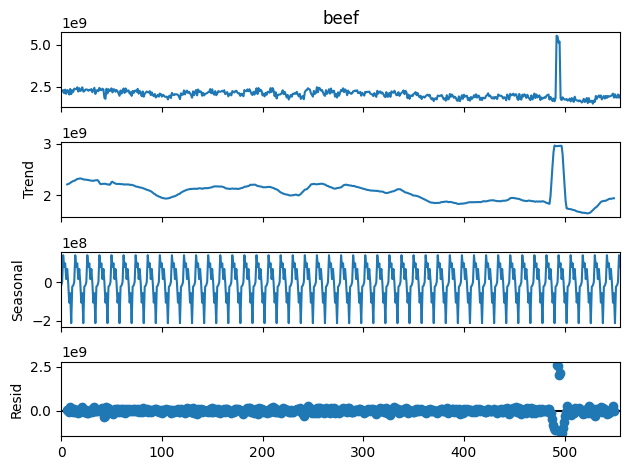

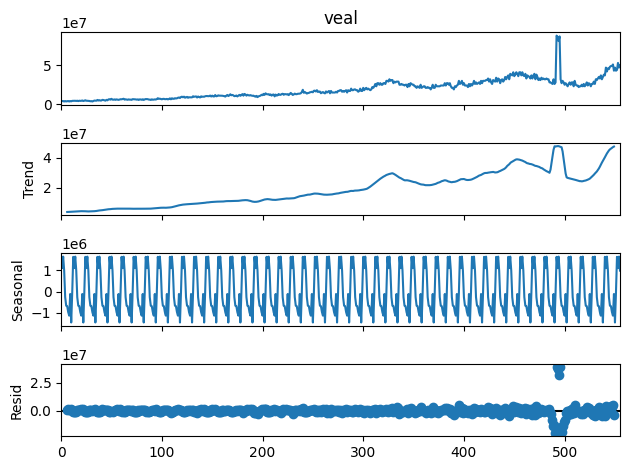

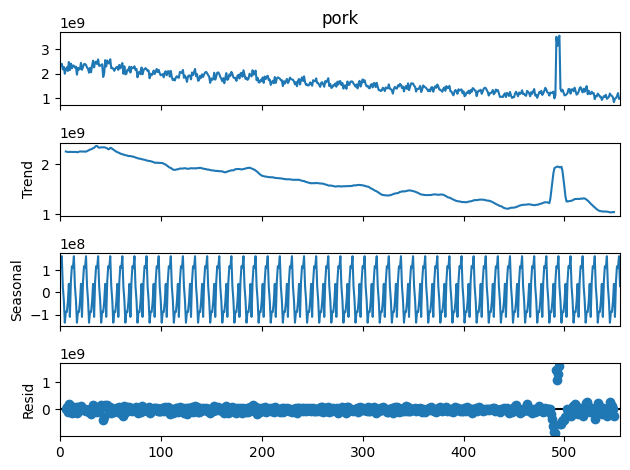

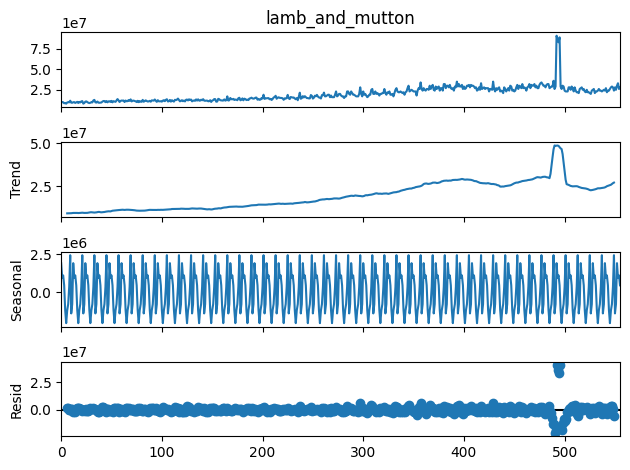

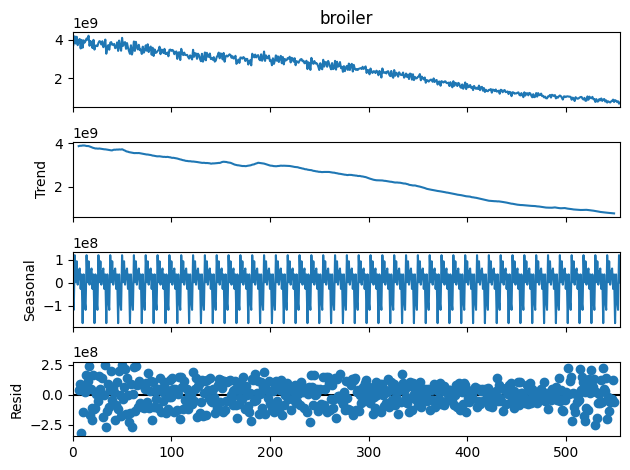

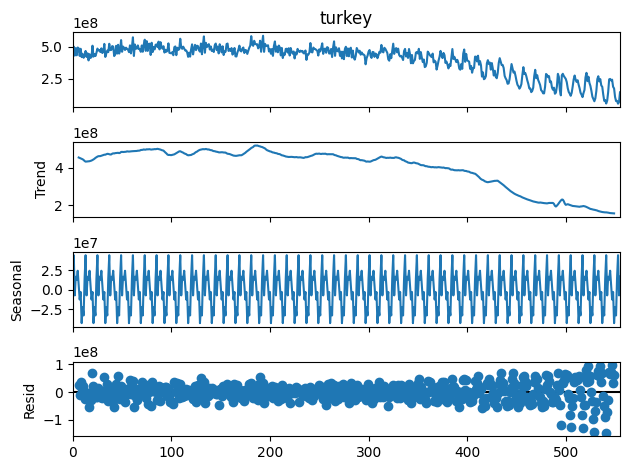

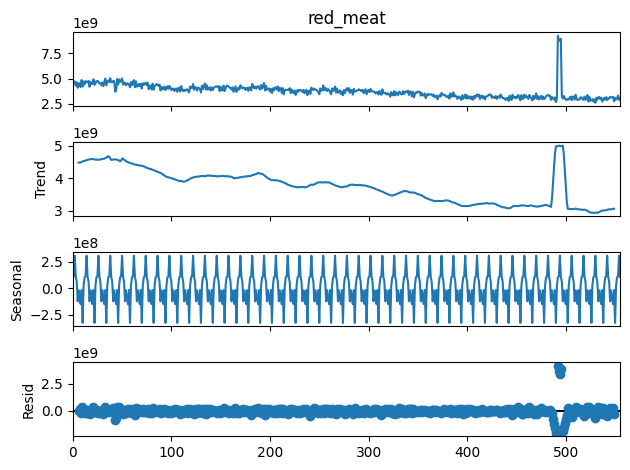

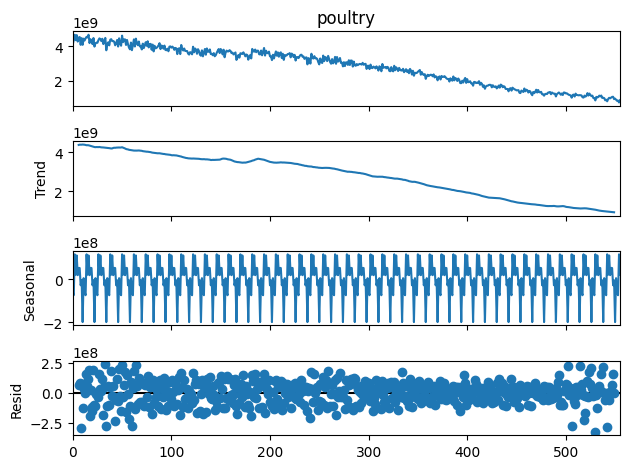

In [172]:
df_subject1_resid = df_subject1.copy()
for meat in MEAT_TYPE:
    decomposition = seasonal_decompose(df_subject1[meat], model='additive', period=12)
    residual = decomposition.resid
    decomposition.plot()
    df_subject1_resid[f'residual_{meat}'] = residual

df_subject1_resid = df_subject1_resid.dropna()
stationary = 0
for meat in MEAT_TYPE:
    if test_stationarity(df_subject1_resid[f'residual_{meat}'], meat):
        stationary += 1
    else:
        print(f'Residual for {meat} is not stationary. Consider differencing or detrending.')
    print('\n')

print(f'Number of stationary residuals: {stationary}/{len(MEAT_TYPE)}')
df_subject1_resid = df_subject1_resid.drop(columns=MEAT_TYPE)
df_subject1_resid

Check if unemployment rates is stationary

In [173]:
test_stationarity(df_subject2[SUBJECT2], SUBJECT2)

Augmented Dickey-Fuller Test Results for Hourly Earnings:
-------------------------------------
Test Statistic: 3.0547
P-value: 1.0000
Number of Lags Used: 14
Number of Observations Used: 202
Critical Values:
    1% (-3.4631)
    5% (-2.8760)
    10% (-2.5745)
Information Criterion (best): -167.0112
Conclusion:
The time series is not stationary. Consider differencing or detrending.


0

Get residual from seasonal trend decomposition

Augmented Dickey-Fuller Test Results for Hourly Earnings:
-------------------------------------
Test Statistic: -6.3341
P-value: 0.0000
Number of Lags Used: 14
Number of Observations Used: 190
Critical Values:
    1% (-3.4652)
    5% (-2.8769)
    10% (-2.5749)
Information Criterion (best): -300.9680
Conclusion:
The time series is stationary with 95% confidence.


,datetime,residual_hourly_earnings
6,2006-09-01,-0.019051
7,2006-10-01,0.084450
8,2006-11-01,-0.026261
9,2006-12-01,0.039989
10,2007-01-01,-0.091064
...,...,...
206,2023-05-01,-0.097878
207,2023-06-01,-0.065795
208,2023-07-01,0.260112
209,2023-08-01,-0.012780


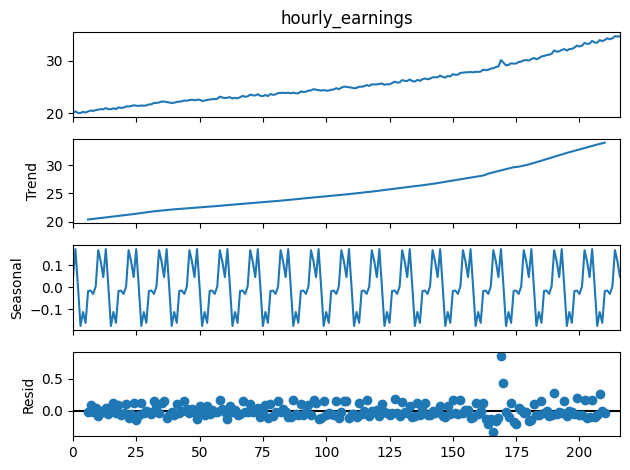

In [174]:
df_subject2_resid = df_subject2.copy()
decomposition = seasonal_decompose(df_subject2[SUBJECT2], model='additive', period=12)
decomposition.plot()
residual = decomposition.resid
df_subject2_resid[f'residual_{SUBJECT2}'] = residual
df_subject2_resid = df_subject2_resid.dropna()
test_stationarity(df_subject2_resid[f'residual_{SUBJECT2}'], SUBJECT2)

df_subject2_resid = df_subject2_resid.drop(columns=[SUBJECT2])
df_subject2_resid

Merge into one dataset for use

In [175]:
common_start = max(df_subject1_resid['datetime'].min(), df_subject2_resid['datetime'].min())
common_end = min(df_subject1_resid['datetime'].max(), df_subject2_resid['datetime'].max())

df_subject1_resid = df_subject1_resid[(df_subject1_resid['datetime'] >= common_start) & (df_subject1_resid['datetime'] <= common_end)]
df_subject2_resid = df_subject2_resid[(df_subject2_resid['datetime'] >= common_start) & (df_subject2_resid['datetime'] <= common_end)]

merged_df = pd.merge(df_subject1_resid, df_subject2_resid, on='datetime')

# Correlation Analysis

Get correlation between the different meat types and subject

/var/folders/_z/09vrqlq533g4mwf_3hh2dzrc0000gn/T/ipykernel_70185/3716570335.py:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, cor, use_line_collection=True)


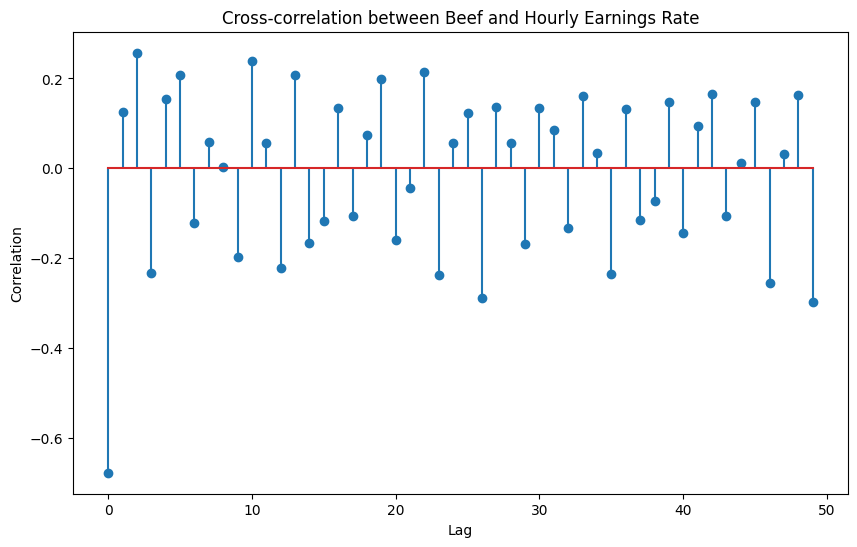

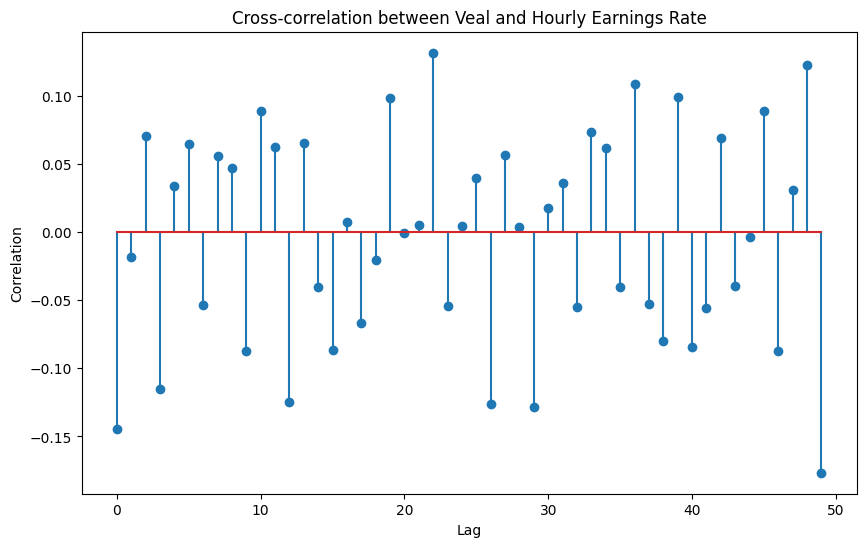

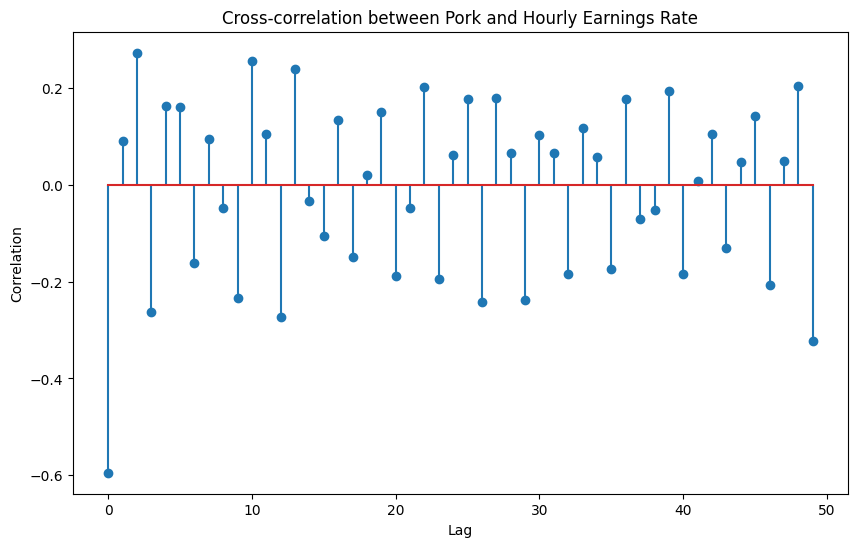

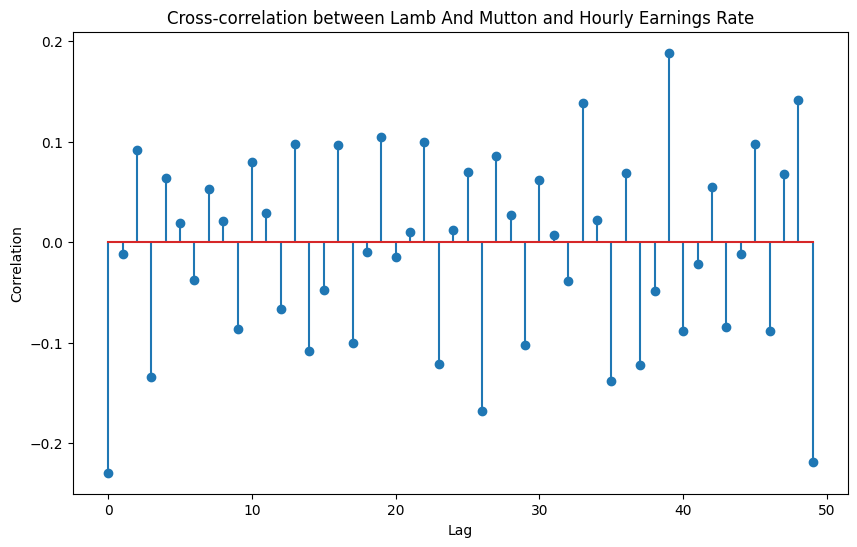

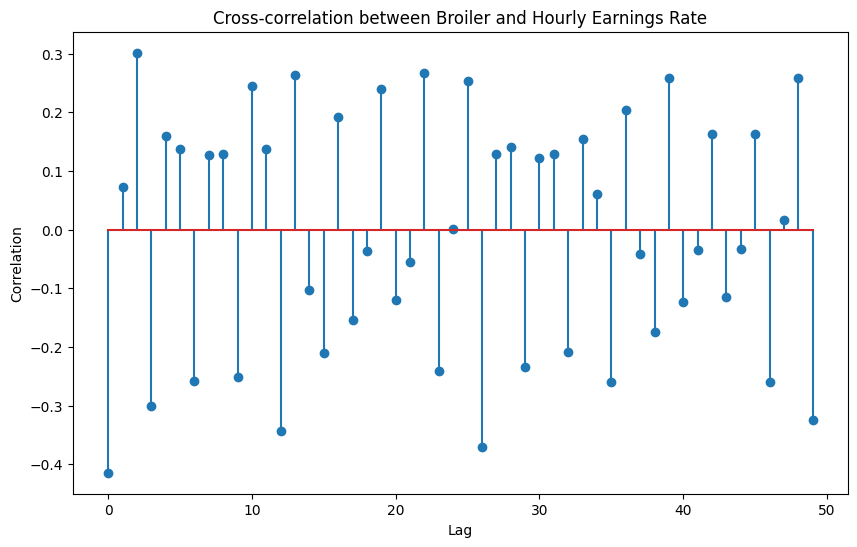

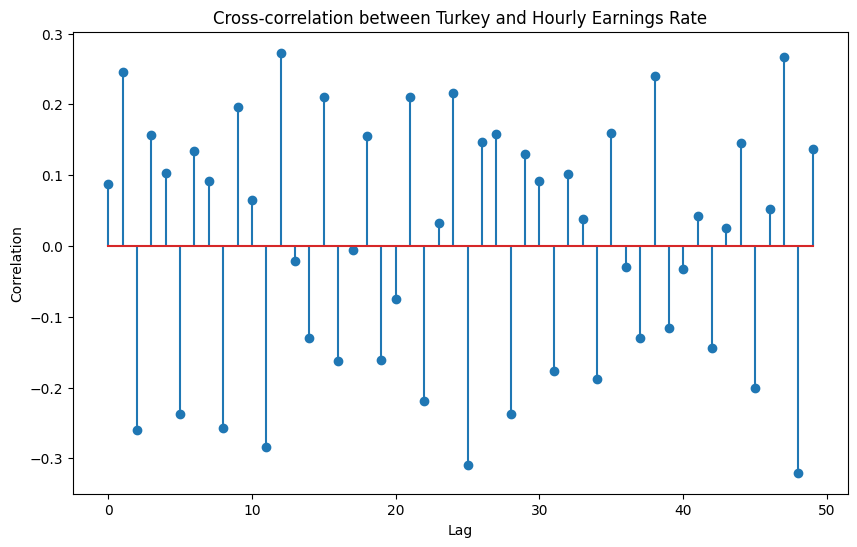

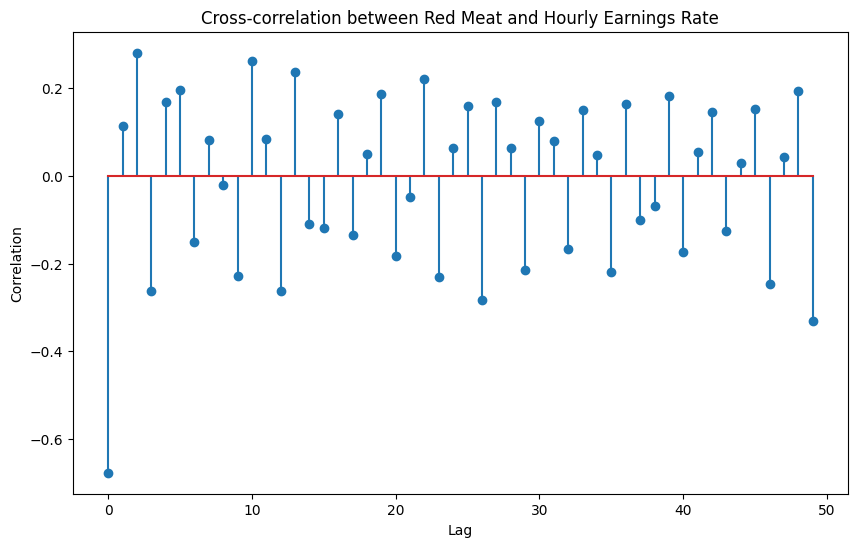

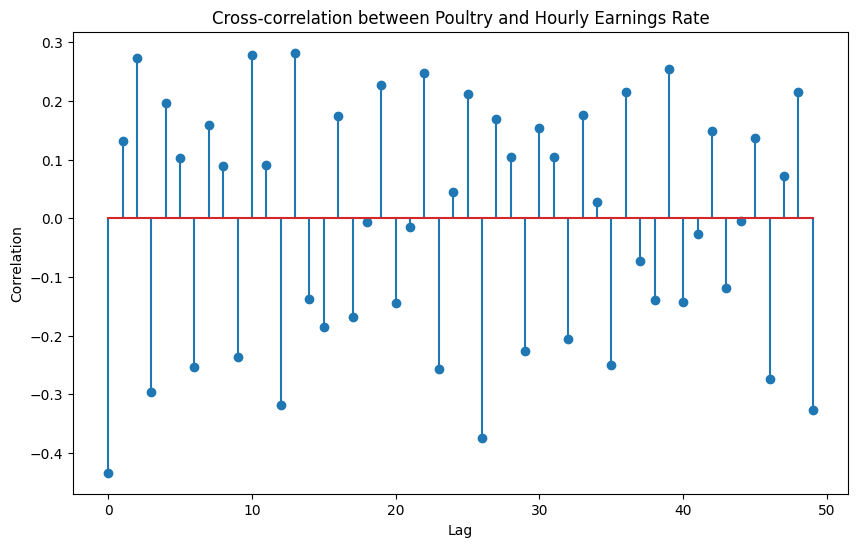

Correlation between Meat Production and Hourly Earnings Rate:
-------------------------------------
Beef: -0.6784, p-value: 0.0000
Veal: -0.1447, p-value: 0.0399
Pork: -0.5948, p-value: 0.0000
Lamb And Mutton: -0.2292, p-value: 0.0010
Broiler: -0.4143, p-value: 0.0000
Turkey: 0.0876, p-value: 0.2150
Red Meat: -0.6774, p-value: 0.0000
Poultry: -0.4335, p-value: 0.0000


In [176]:
for meat in MEAT_TYPE:
    max_lag = 50
    cor = ccf(merged_df[f'residual_{meat}'], merged_df[f'residual_{SUBJECT2}'], adjusted=False)[:max_lag]
    lags = np.arange(max_lag)
    plt.figure(figsize=(10, 6))
    plt.stem(lags, cor, use_line_collection=True)
    plt.title(f"Cross-correlation between {meat.replace('_', ' ').title()} and {SUBJECT_TITLE2} Rate")
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.show()

# Get correlation between each meat type and subject rate
correlation = {}
for meat in MEAT_TYPE:
    correlation[meat] = stats.pearsonr(merged_df[f'residual_{meat}'], merged_df[f'residual_{SUBJECT2}'])

# Format the correlation values and print them
print(f"Correlation between Meat Production and {SUBJECT_TITLE2} Rate:")
print("-------------------------------------")
for cor in correlation:
    print(f"{cor.replace('_', ' ').title()}: {correlation[cor][0]:.4f}, p-value: {correlation[cor][1]:.4f}")


# (Granger) Causal Analysis

In [177]:
print(MEAT_TYPE)
gc_res = grangercausalitytests(merged_df[[f'residual_{MEAT_TYPE[4]}', f'residual_{SUBJECT2}']], maxlag=12)

['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'red_meat', 'poultry']

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0650  , p=0.3033  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=1.0811  , p=0.2985  , df=1
likelihood ratio test: chi2=1.0782  , p=0.2991  , df=1
parameter F test:         F=1.0650  , p=0.3033  , df_denom=198, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.1114 , p=0.0001  , df_denom=195, df_num=2
ssr based chi2 test:   chi2=20.7413 , p=0.0000  , df=2
likelihood ratio test: chi2=19.7348 , p=0.0001  , df=2
parameter F test:         F=10.1114 , p=0.0001  , df_denom=195, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.5470  , p=0.0003  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=20.3572 , p=0.0001  , df=3
likelihood ratio test: chi2=19.3819 , p=0.0002  , df=3
parameter F test:         F=6.5470  , p=0.0003  , df_denom=192, df_num=3

Grang

In [178]:
gc_diff = grangercausalitytests(diff_df[[f'{SUBJECT2}', f'{MEAT_TYPE[0]}']], maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.4391 , p=0.0000  , df_denom=211, df_num=1
ssr based chi2 test:   chi2=20.7297 , p=0.0000  , df=1
likelihood ratio test: chi2=19.7862 , p=0.0000  , df=1
parameter F test:         F=20.4391 , p=0.0000  , df_denom=211, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4915  , p=0.0018  , df_denom=208, df_num=2
ssr based chi2 test:   chi2=13.2951 , p=0.0013  , df=2
likelihood ratio test: chi2=12.8967 , p=0.0016  , df=2
parameter F test:         F=6.4915  , p=0.0018  , df_denom=208, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.0918  , p=0.0005  , df_denom=205, df_num=3
ssr based chi2 test:   chi2=18.8993 , p=0.0003  , df=3
likelihood ratio test: chi2=18.1038 , p=0.0004  , df=3
parameter F test:         F=6.0918  , p=0.0005  , df_denom=205, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1915  , p=0.0028  

# ARIMA

Split train test data

In [179]:
# Flip the dateframe so that the most recent data is at the bottom

diff_df.reset_index(drop=True, inplace=True)

train_df = diff_df[diff_df['datetime'].dt.year < 2019]
test_df = diff_df[diff_df['datetime'].dt.year >= 2019]

print(train_df)
print(test_df)

      datetime         beef       veal         pork  lamb_and_mutton  \
58  2018-12-01 -187300000.0  -100000.0 -141600000.0         500000.0   
59  2018-11-01  197200000.0   300000.0  116300000.0        -100000.0   
60  2018-10-01  107100000.0   400000.0   99200000.0         100000.0   
61  2018-09-01 -266600000.0 -1100000.0 -436200000.0       -1800000.0   
62  2018-08-01  272500000.0   400000.0  302100000.0        1800000.0   
..         ...          ...        ...          ...              ...   
210 2006-04-01 -337600000.0 -2400000.0 -106200000.0         600000.0   
211 2006-03-01  231000000.0  2300000.0  256700000.0        1500000.0   
212 2006-02-01 -374400000.0 -1300000.0 -238600000.0       -3600000.0   
213 2006-01-01  220200000.0   400000.0  182900000.0        1300000.0   
214 2005-12-01    8900000.0  1600000.0   43800000.0         500000.0   

         broiler       turkey     red_meat      poultry  hourly_earnings  
58  -482600000.0   49300000.0 -328500000.0 -442200000.0     

Do ARIMA for beef in forecasting wages

Figure(1500x1200)


/Users/jezza/Desktop/CompSci-Year2/citadel-datathon/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jezza/Desktop/CompSci-Year2/citadel-datathon/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jezza/Desktop/CompSci-Year2/citadel-datathon/.venv/lib/python3.12/site-packages/statsmodels/base/optimizer.py:736: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/Users/jezza/Desktop/CompSci-Year2/citadel-datathon/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

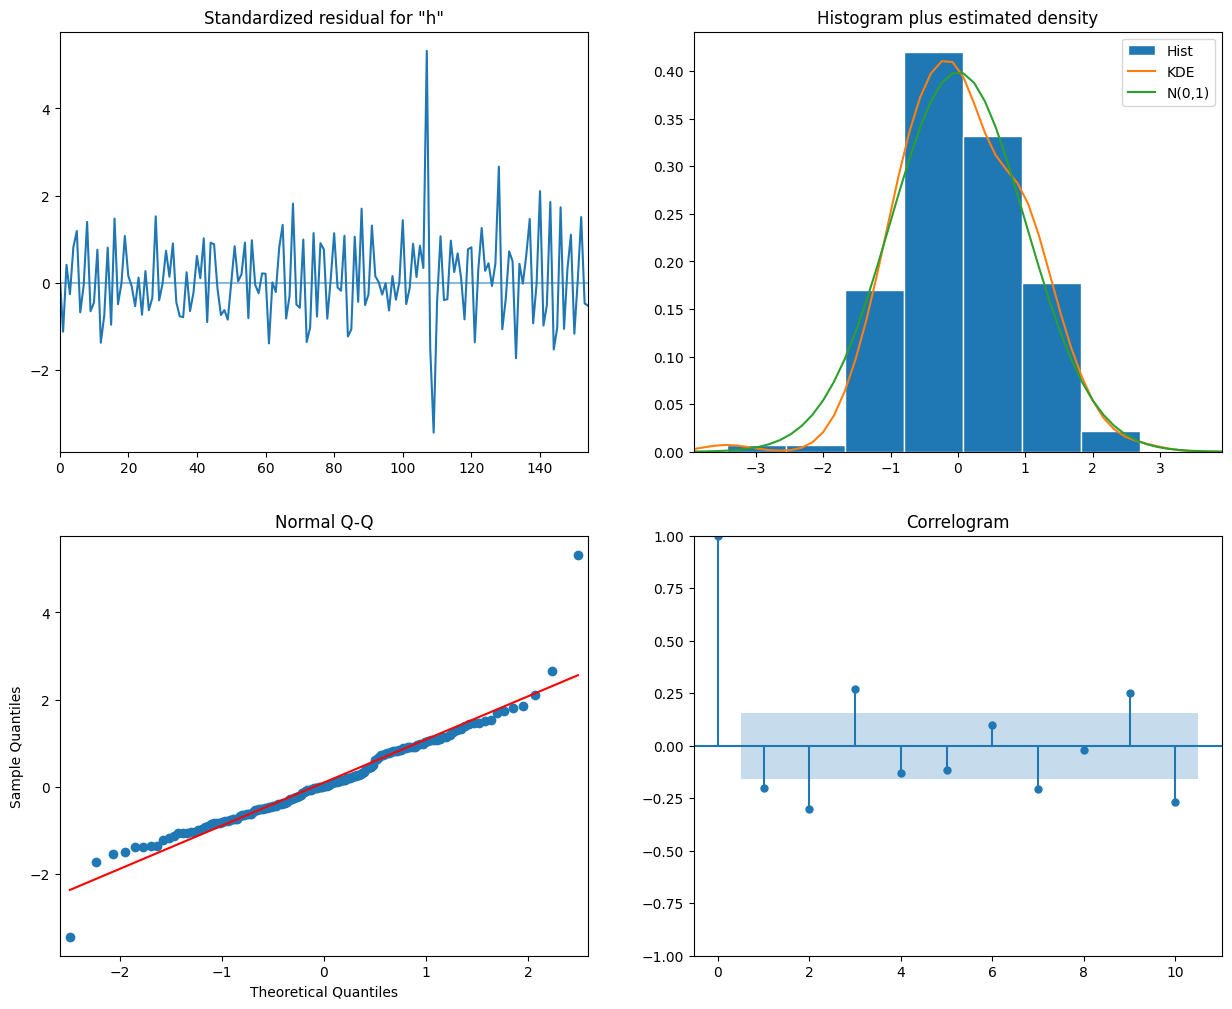

In [180]:
y = train_df[f'{SUBJECT2}']
x = train_df[f'{MEAT_TYPE[0]}']

p, d, q = 1, 0, 1
P, D, Q, s = 0, 0, 0, 12

model = SARIMAX(y, exog=x,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False,
                maxiter=10000)
model_fit = model.fit(method='nm')
print(model_fit.plot_diagnostics(figsize=(15, 12)))

In [182]:
forecast = model_fit.get_forecast(steps=len(test_df), exog=test_df[f'{MEAT_TYPE[0]}'])

# diff_df = diff_df.dropna()
# undiff_df.to_csv('undiff_df.csv', index=False)
# undiff_df = undiff_df.drop(undiff_df.tail(1).index,inplace=True) # drop last n rows



# x, x_diff = undiff_df['hourly_earnings'].iloc[0], diff_df['hourly_earnings'].iloc[1:]
# undiff_df['hourly_earnings_fixed'] = np.r_[x, x_diff].cumsum().astype(int)
print(forecast.predicted_mean)


# forecast.reset_index(drop=True, inplace=True)

result = pd.DataFrame({
    'Actual': test_df[f'{SUBJECT2}'],
    'Predicted': forecast.predicted_mean.values
})

result.to_csv('result.csv', index=False)

157    0.090187
158   -0.020131
159    0.004589
160   -0.001162
161    0.000376
162   -0.000071
163   -0.000155
164    0.000232
165   -0.000217
166    0.000161
167   -0.000066
168    0.000137
169   -0.000017
170   -0.000009
171    0.000082
172   -0.000178
173    0.000142
174   -0.000117
175    0.000028
176    0.000124
177   -0.000177
178    0.000010
179    0.000069
180    0.000011
181   -0.000013
182   -0.000046
183    0.000045
184   -0.000028
185    0.000053
186   -0.000132
187    0.000095
188    0.000093
189   -0.000260
190    0.000142
191    0.000014
192   -0.000042
193    0.000141
194   -0.000082
195   -0.000012
196    0.000061
197   -0.000035
198   -0.000358
199   -0.000032
200    0.000422
201   -0.000194
202    0.000178
203   -0.000083
204    0.000023
205    0.000093
206   -0.000172
207    0.000131
208   -0.000008
209   -0.000096
210    0.000071
211   -0.000047
212   -0.000102
213   -0.000091
214    0.000224
Name: predicted_mean, dtype: float64


/Users/jezza/Desktop/CompSci-Year2/citadel-datathon/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
